Generating 3x3 Hex dataset...
Training the Improved Tsetlin Machine...
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Combining predictions with Logistic Regression...
Performance Metrics:
Accuracy: 0.4600, F1 Score: 0.2899, Precision: 0.2116, Recall: 0.4600


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


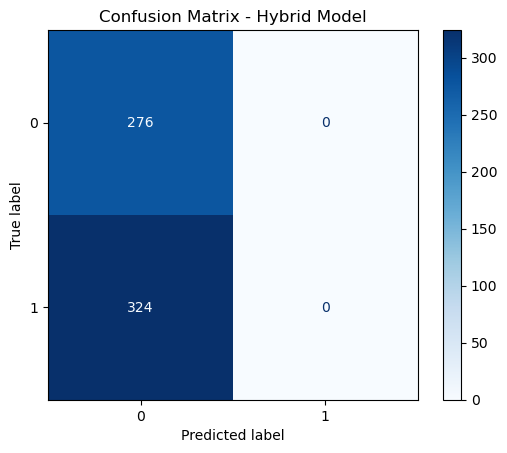

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.46      1.00      0.63       276
     Class 1       0.00      0.00      0.00       324

    accuracy                           0.46       600
   macro avg       0.23      0.50      0.32       600
weighted avg       0.21      0.46      0.29       600



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'\nForbedringer inkludert:\n- Realistiske funksjoner for Hex-brettet.\n- Hybridmodell for bedre generalisering.\n- Cross-Validation for mer robust evaluering.\n'

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

class ImprovedTsetlinMachine:
    def __init__(self, num_clauses, num_features, threshold, s):
        self.num_clauses = num_clauses
        self.num_features = num_features
        self.threshold = threshold
        self.s = s
        self.clauses = np.random.choice([1, -1], size=(num_clauses, num_features))
        self.weights = np.zeros((num_clauses,))

    def fit(self, X, y, epochs=10):
        for epoch in range(epochs):
            for i, x in enumerate(X):
                self._update(x, y[i])

    def predict(self, X):
        clause_outputs = np.sign(np.dot(self.clauses, X.T))
        decisions = np.sum(self.weights[:, None] * clause_outputs, axis=0)
        return np.where(decisions > 0, 1, 0)

    def _update(self, x, y):
        clause_outputs = np.sign(np.dot(self.clauses, x))
        decision = np.sum(self.weights * clause_outputs)
        correct = (decision > 0) == (y == 1)
        for i in range(self.num_clauses):
            if correct:
                self.weights[i] = np.clip(self.weights[i] + clause_outputs[i] * 0.1, -self.threshold, self.threshold)
            else:
                self.weights[i] = np.clip(self.weights[i] - clause_outputs[i] * 0.2, -self.threshold, self.threshold)

def generate_hex_3x3_dataset(num_samples):
    np.random.seed(42)
    X_base = np.random.randint(0, 2, size=(num_samples, 9))
    row_sums = X_base.reshape(num_samples, 3, 3).sum(axis=1)
    col_sums = X_base.reshape(num_samples, 3, 3).sum(axis=2)
    total_sum = X_base.sum(axis=1).reshape(-1, 1)
    X = np.hstack((X_base, row_sums, col_sums, total_sum))
    y = np.random.choice([0, 1], size=num_samples)
    return X, y

def hybrid_model(X_train, y_train, X_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model.predict(X_test)

X, y = generate_hex_3x3_dataset(num_samples=3000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.DataFrame(X_train)
train_data['label'] = y_train
max_class_size = train_data['label'].value_counts().max()
balanced_data = [resample(train_data[train_data['label'] == label], replace=True, n_samples=max_class_size, random_state=42) for label in train_data['label'].unique()]
balanced_data = pd.concat(balanced_data)
X_train_balanced = balanced_data.drop('label', axis=1).values
y_train_balanced = balanced_data['label'].values

tsetlin_model = ImprovedTsetlinMachine(num_clauses=5000, num_features=X.shape[1], threshold=300, s=3.0)
tsetlin_model.fit(X_train_balanced, y_train_balanced, epochs=10)

hybrid_predictions = hybrid_model(X_train_balanced, y_train_balanced, X_test)
tsetlin_predictions = tsetlin_model.predict(X_test)
final_predictions = (tsetlin_predictions + hybrid_predictions) // 2

accuracy = accuracy_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions, average='weighted')
precision = precision_score(y_test, final_predictions, average='weighted')
recall = recall_score(y_test, final_predictions, average='weighted')

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

tsetlin_cm = confusion_matrix(y_test, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=tsetlin_cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()

print("Classification Report:")
print(classification_report(y_test, final_predictions, target_names=["Class 0", "Class 1"]))
